特定的“&lt;eos&gt;”表示序列结束词元。
一旦输出序列生成此词元，模型就会停止预测。
在循环神经网络解码器的初始化时间步，有两个特定的设计决定：
- 首先，特定的“&lt;bos&gt;”表示序列开始词元，它是解码器的输入序列的第一个词元。
- 其次，使用循环神经网络编码器最终的隐状态来初始化解码器的隐状态。

In [2]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class Encoder(nn.Module):
    """编码器-解码器架构的基本编码器接口"""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

class Decoder(nn.Module):
    """编码器-解码器架构的基本解码器接口"""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

class EncoderDecoder(nn.Module):
    """编码器-解码器架构的基类"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)     

## Encoder

考虑由一个序列组成的样本（批量大小是$1$）。
假设输入序列是$x_1, \ldots, x_T$，
其中$x_t$是输入文本序列中的第$t$个词元。
在时间步$t$，循环神经网络将词元$x_t$的输入特征向量
$\mathbf{x}_t$和$\mathbf{h} _{t-1}$（即上一时间步的隐状态）
转换为$\mathbf{h}_t$（即当前步的隐状态）。
使用一个函数$f$来描述循环神经网络的循环层所做的变换：

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). $$

编码器通过选定的函数$q$，
将所有时间步的隐状态转换为上下文变量：

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

比如，当选择$q(\mathbf{h}_1, \ldots, \mathbf{h}_T) = \mathbf{h}_T$时，
上下文变量仅仅是输入序列在最后时间步的隐状态$\mathbf{h}_T$。

使用了*嵌入层*（embedding layer）
来获得输入序列中每个词元的特征向量。
嵌入层的权重是一个矩阵，
其行数等于输入词表的大小（`vocab_size`），
其列数等于特征向量的维度（`embed_size`）。
对于任意输入词元的索引$i$，
嵌入层获取权重矩阵的第$i$行（从$0$开始）以返回其特征向量。


In [4]:
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size,embed_size) # (vocab_size, embed_size) 每个词都有一个特征向量
        self.rnn = nn.GRU(embed_size,num_hiddens,num_layers,dropout=dropout) # input_size = embed_size

    def forward(self,x,*args):
        # 输入'x'的形状：(batch_size,num_steps)
        x = self.embedding(x) # embedding后'X'的形状：(batch_size,num_steps,embedded size)
        x = x.permute(1,0,2) # 在循环神经网络模型中，第一个轴对应于时间步
        # nn.GRU的输出是(每个时间步的隐藏状态，最后一步的隐藏状态)
        output,state = self.rnn(x) # output的形状:(num_steps,batch_size,num_hiddens) / state的形状:(num_layers,batch_size,num_hiddens)
        return output,state

编码器输出的上下文变量$\mathbf{c}$
对整个输入序列$x_1, \ldots, x_T$进行编码。
来自训练数据集的输出序列$y_1, y_2, \ldots, y_{T'}$，
对于每个时间步$t'$（与输入序列或编码器的时间步$t$不同），
解码器输出$y_{t'}$的概率取决于先前的输出子序列
$y_1, \ldots, y_{t'-1}$和上下文变量$\mathbf{c}$，
即$P(y_{t'} \mid y_1, \ldots, y_{t'-1}, \mathbf{c})$。

为了在序列上模型化这种条件概率，
我们可以使用另一个循环神经网络作为解码器。
在输出序列上的任意时间步$t^\prime$，
循环神经网络将来自上一时间步的输出$y_{t^\prime-1}$
和上下文变量$\mathbf{c}$作为其输入，
然后在当前时间步将它们和上一隐状态
$\mathbf{s}_{t^\prime-1}$转换为
隐状态$\mathbf{s}_{t^\prime}$。
因此，可以使用函数$g$来表示解码器的隐藏层的变换：

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$

**当实现解码器时，
我们直接使用编码器最后一个时间步的隐状态来初始化解码器的隐状态。
这就要求使用循环神经网络实现的编码器和解码器具有相同数量的层和隐藏单元。
为了进一步包含经过编码的输入序列的信息，
上下文变量在所有的时间步与解码器的输入进行拼接（concatenate）。
为了预测输出词元的概率分布，
在循环神经网络解码器的最后一层使用全连接层来变换隐状态.**

In [14]:
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 要将Encoder的output(即上下文变量)与当前时间步的输入进行拼接
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,dropout=dropout) 
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self,x,state):
        x = self.embedding(x).permute(1,0,2)
        context = state[-1].repeat(x.shape[0],1,1) #state[-1]:(batch_size,num_hiddens) -> repeat后(num_steps,batch_size,num_hiddens)
        output, state = self.rnn(torch.cat((x,context),2), state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

## 损失函数

在每个时间步，解码器预测了输出词元的概率分布。
类似于语言模型，可以使用softmax来获得分布，
并通过计算交叉熵损失函数来进行优化。
在之前特定的填充词元被添加到序列的末尾，
因此不同长度的序列可以以相同形状的小批量加载。
但是，我们应该将填充词元的预测排除在损失函数的计算之外。

为此，我们可以使用下面的`sequence_mask`函数
[**通过零值化屏蔽不相关的项**]，
以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。

In [9]:
def sequence_mask(X,valid_len,value = 0):
    # X:(batch_size,num_steps)  valid_len:有效长度  value:填充值
    maxlen = X.size(1)
    # [None,:]后:(1,maxlen) valid_len:(batch_size,1) 然后通过广播机制比较
    mask = torch.arange((maxlen),dtype = torch.float32,device = X.device)[None,:] < valid_len[:,None]
    X[~mask] = value
    return X

In [10]:
# 测试sequence_mask
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [11]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label) # 先初始化为1
        weights = sequence_mask(weights, valid_len) # 将填充词的权重设为0
        self.reduction = 'none'
        #(batch_size, num_steps, vocab_size) -> (batch_size, vocab_size, num_steps)，为了满足交叉熵的输入要求，即类别必须是第二个维度
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

特定的序列开始词元（“&lt;bos&gt;”）和
原始的输出序列（不包括序列结束词元“&lt;eos&gt;”）
拼接在一起作为解码器的输入。
这被称为*强制教学*（teacher forcing），
因为原始的输出序列（词元的标签）被送入解码器。

In [15]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    # 初始化
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss() # 用我们定义的损失函数
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',xlim=[10, num_epochs]) # 画图函数
    for epoch in range(num_epochs):
        timer = d2l.Timer() # 计时函数
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],device=device).reshape(-1, 1) # 序列开始标记
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学，即用不管前一个预测出的词是什么，下一个依然用真实的词作为输入
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()	# 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1) # 之前定义的梯度裁剪函数
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} 'f'tokens/sec on {str(device)}')

loss 0.018, 25800.9 tokens/sec on cuda:0


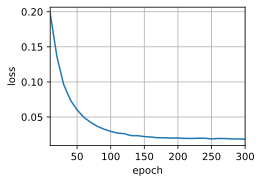

In [16]:
# 在机器翻译数据集上测试
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [19]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,device):
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>']) # 截断或填充
    # 添加批量轴
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq = []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入，这与训练时的teacher forcing不同
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq))

我们将BLEU定义为：

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$

其中$\mathrm{len}_{\text{label}}$表示标签序列中的词元数和
$\mathrm{len}_{\text{pred}}$表示预测序列中的词元数，
$k$是用于匹配的最长的$n$元语法。
另外，用$p_n$表示$n$元语法的精确度，它是两个数量的比值：
第一个是预测序列与标签序列中匹配的$n$元语法的数量，
第二个是预测序列中$n$元语法的数量的比率。

，
当预测序列与标签序列完全相同时，BLEU为$1$。
此外，由于$n$元语法越长则匹配难度越大，
所以BLEU为更长的$n$元语法的精确度分配更大的权重。
具体来说，当$p_n$固定时，$p_n^{1/2^n}$
会随着$n$的增长而增加（原始论文使用$p_n^{1/n}$）。
而且，由于预测的序列越短获得的$p_n$值越高，
所以乘法项之前的系数用于惩罚较短的预测序列。

In [18]:
def bleu(pred_seq, label_seq, k):
    # k:最大的n(n-gram)
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [21]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation= predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est paresseux est ., bleu 0.548
i'm home . => je suis gras ., bleu 0.512
